<h4 style='text-align: left;'> Problem 1 </h4>

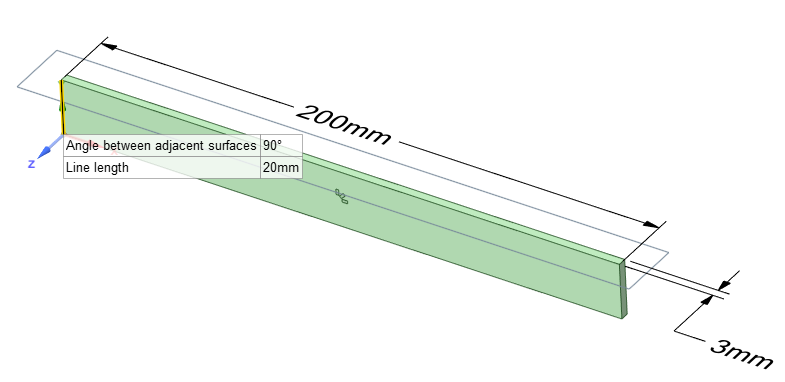

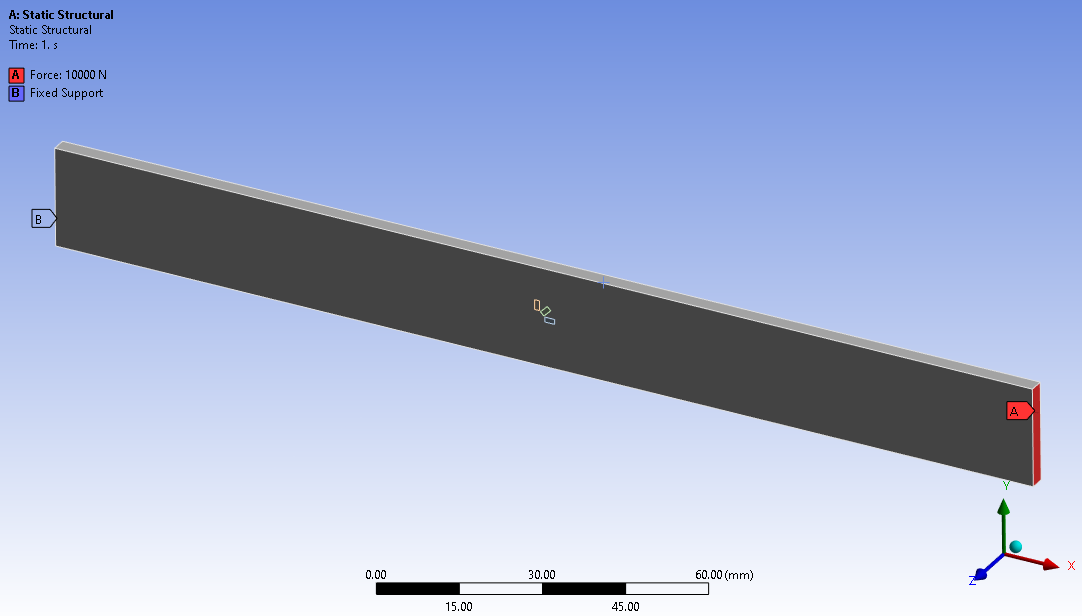

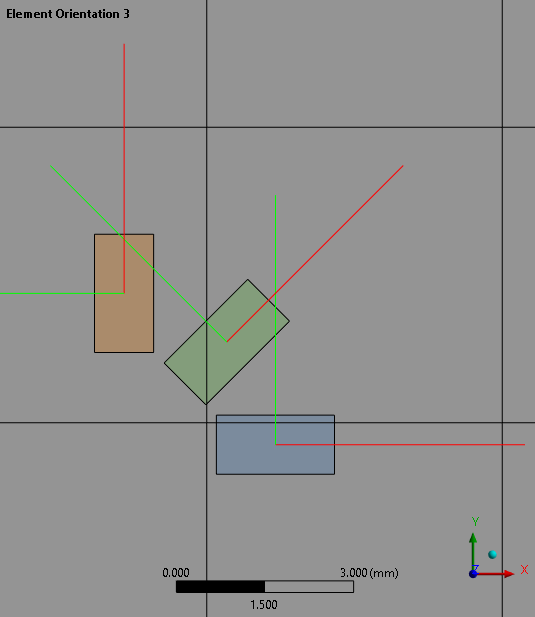

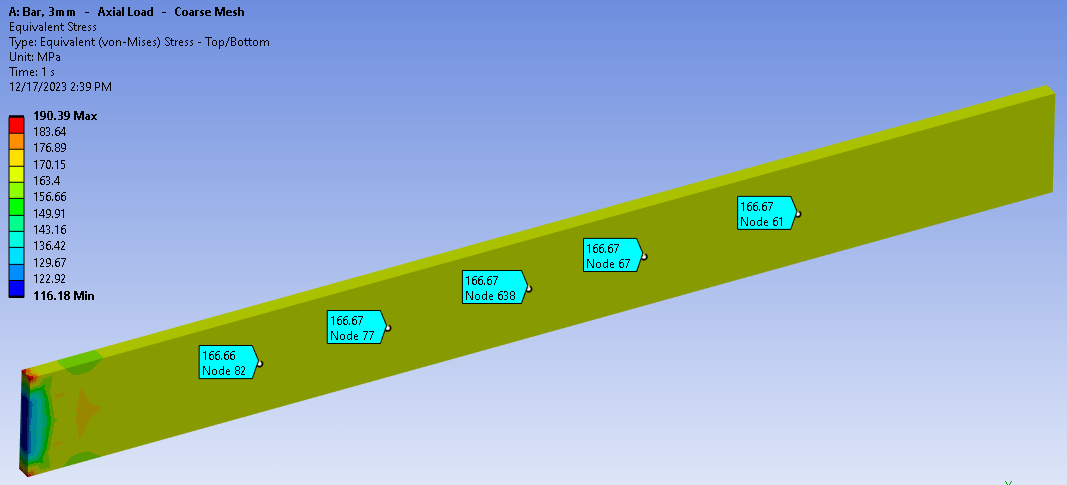

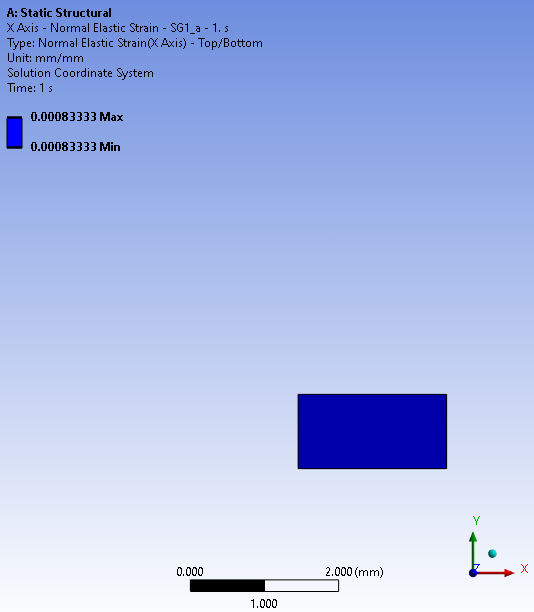 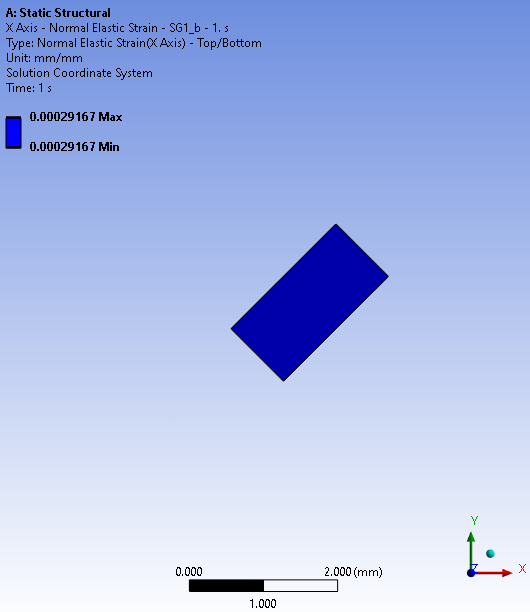 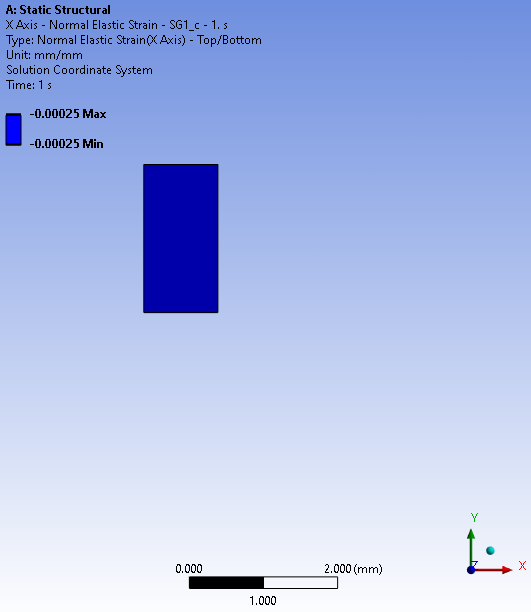

In [1]:
# Libraries

import numpy as np

### **Measured input data:**
*  Material Properties:
    -  Young's Modulus: 210 MPa
    -  Poisson's ratio: 0.3

In [2]:
E  = 200                     # GPa 
nu = 0.3                     # Poisson's ratio

# ANSYS Plane Stress (3mm thickness, axial)
epsilon_A_measured = 833.33     # Microstrain
epsilon_B_measured = 291.67     # Microstrain
epsilon_C_measured =-250.00    # Microstrain

**Setting up gauge angles**

In [3]:

# Angles for the strain gauges A, B, and C (in degrees)
theta_A_deg = 0      # Theta_A is 0 degrees
theta_B_deg = 45    # Theta_B is -45 degrees
theta_C_deg = 90    # Theta_C is -90 degrees

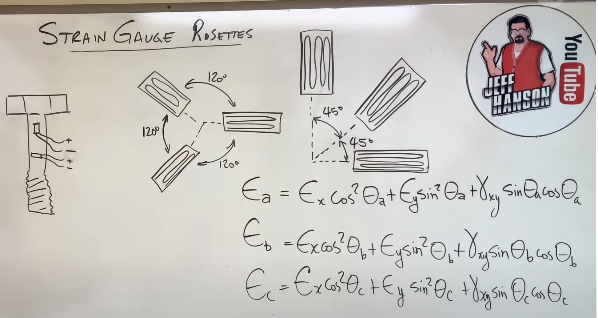

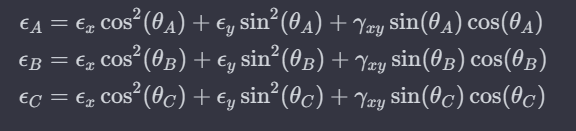

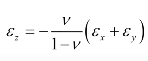

In [4]:
def calculate_strains(theta_A_deg, theta_B_deg, theta_C_deg, epsilon_A_measured, epsilon_B_measured, epsilon_C_measured, nu):
    """
    Calculate the normal strains in the x and y directions, shear strain, and the third principal strain.
    
    Parameters:
    theta_A_deg (float): Angle of gauge A in degrees.
    theta_B_deg (float): Angle of gauge B in degrees.
    theta_C_deg (float): Angle of gauge C in degrees.
    epsilon_A_measured (float): Measured strain at gauge A in microstrain.
    epsilon_B_measured (float): Measured strain at gauge B in microstrain.
    epsilon_C_measured (float): Measured strain at gauge C in microstrain.
    nu (float): Poisson's ratio (dimensionless).
    
    Returns:
    float, float, float, float: Normal strains in the x and y directions, shear strain, and the third principal strain.
    """
    # Convert angles to radians for calculation
    theta_A_rad = np.radians(theta_A_deg)
    theta_B_rad = np.radians(theta_B_deg)
    theta_C_rad = np.radians(theta_C_deg)

    # Constructing the coefficient matrix from the equations
    coeff_matrix = np.array([
        [np.cos(theta_A_rad)**2, np.sin(theta_A_rad)**2, np.sin(theta_A_rad) * np.cos(theta_A_rad)],
        [np.cos(theta_B_rad)**2, np.sin(theta_B_rad)**2, np.sin(theta_B_rad) * np.cos(theta_B_rad)],
        [np.cos(theta_C_rad)**2, np.sin(theta_C_rad)**2, np.sin(theta_C_rad) * np.cos(theta_C_rad)]
    ])

    # Constructing the constants vector
    constants_vector = np.array([epsilon_A_measured, epsilon_B_measured, epsilon_C_measured])

    # Solving for the unknowns (normal strains in the x and y directions, and shear strain)
    epsilon_x, epsilon_y, gamma_xy = np.linalg.solve(coeff_matrix, constants_vector)

    # Calculate the third principal strain due to Poisson's effect (normal strain in the z-direction)
    epsilon_z = -nu / (1 - nu) * (epsilon_x + epsilon_y)

    return epsilon_x, epsilon_y, epsilon_z, gamma_xy

epsilon_x, epsilon_y, epsilon_z, gamma_xy = \
calculate_strains(theta_A_deg, theta_B_deg, theta_C_deg, epsilon_A_measured, epsilon_B_measured, epsilon_C_measured, nu)

epsilon_x, epsilon_y, epsilon_z, gamma_xy

(833.33, -250.0, -249.99857142857147, 0.009999999999820373)

In [5]:
def principal_strains(epsilon_x, epsilon_y, gamma_xy):
    # Average of the normal strains
    avg_normal_strain = (epsilon_x + epsilon_y) / 2

    # Radius of Mohr's circle (represents the maximum shear strain)
    R = np.sqrt(((epsilon_x - epsilon_y) / 2) ** 2 + (gamma_xy / 2) ** 2)

    # Principal strains
    epsilon_p1 = avg_normal_strain + R
    epsilon_p2 = avg_normal_strain - R

    return epsilon_p1, epsilon_p2

epsilon_p1, epsilon_p2 = \
principal_strains(epsilon_x, epsilon_y, gamma_xy)

epsilon_p1, epsilon_p2

(833.330000023077, -250.000000023077)

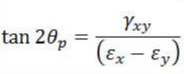

In [6]:
def calculate_principal_strain_orientation(epsilon_x, epsilon_y, gamma_xy):

    # Calculate the value of tan(2*theta_p)
    tan_2theta_p = gamma_xy / (epsilon_x - epsilon_y)

    # Take the arctan (inverse tangent) of that value to find 2*theta_p in radians
    theta_p_2_rad = np.arctan(tan_2theta_p)

    # Divide by 2 to find theta_p in radians
    theta_p_rad = theta_p_2_rad / 2

    # Convert theta_p from radians to degrees
    theta_p_deg = np.degrees(theta_p_rad)

    # Return the orientation of the principal strains in degrees
    return theta_p_deg

theta_p_deg = \
calculate_principal_strain_orientation(epsilon_x, epsilon_y, gamma_xy)

theta_p_deg

0.00026444287294926657

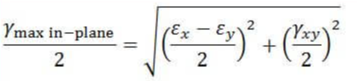

In [7]:
# Calculate the maximum in-plane shear strain
gamma_max_in_plane = np.sqrt(((epsilon_x - epsilon_y) / 2) ** 2 + (gamma_xy / 2) ** 2) * 2

gamma_max_in_plane

1083.330000046154

In [8]:
def calculate_principal_stresses_S1_S2(E, nu, epsilon_p1, epsilon_p2):
    """
    Calculate principal stresses from principal strains.
    
    Parameters:
    E (float): Young's modulus in GPa.
    nu (float): Poisson's ratio (dimensionless).
    epsilon_p1 (float): First principal strain in microstrain.
    epsilon_p2 (float): Second principal strain in microstrain.
    
    Returns:
    float, float: Principal stresses S1 and S2 in MPa.
    """
    # Convert Young's modulus from GPa to MPa and strains from microstrain to strain
    E_mpa = E * 1e3
    epsilon_p1_strain = epsilon_p1 / 1e6
    epsilon_p2_strain = epsilon_p2 / 1e6
    
    # Calculate the principal stresses using the converted values
    S1 = E_mpa / (1 - nu**2) * (epsilon_p1_strain + nu * epsilon_p2_strain)
    S2 = E_mpa / (1 - nu**2) * (epsilon_p2_strain + nu * epsilon_p1_strain)
    
    return S1, S2

S1, S2 = \
calculate_principal_stresses_S1_S2(E, nu, epsilon_p1, epsilon_p2)

S1, S2

(166.66593406948436, -0.0002197837700930514)

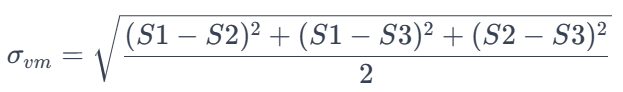

In [9]:
def calculate_von_mises_stress(S1, S2, S3=0.0):
    """
    Calculate the von Mises stress from the principal stresses.
    
    Parameters:
    S1 (float): First principal stress in MPa.
    S2 (float): Second principal stress in MPa.
    S3 (float): Third principal stress in MPa, assumed to be zero for plane stress condition.
    
    Returns:
    float: The von Mises stress in MPa.
    """
    # Calculate the von Mises stress using the principal stresses
    sigma_vm = np.sqrt(((S1 - S2)**2 + (S1 - S3)**2 + (S2 - S3)**2) / 2)
    return sigma_vm

sigma_vm = \
calculate_von_mises_stress(S1, S2)

sigma_vm

166.6660439614781

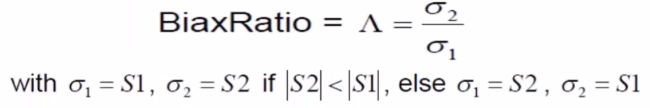

In [10]:
def calculate_biaxiality_ratio(S1, S2):
    """
    Calculate the biaxiality ratio from the principal stresses.

    Parameters:
    S1 (float): First principal stress in MPa.
    S2 (float): Second principal stress in MPa.

    Returns:
    float: The biaxiality ratio.
    """
    if abs(S2) <= abs(S1):
        sigma_1 = S1
        sigma_2 = S2
    else:
        sigma_1 = S2
        sigma_2 = S1
    
    # Calculate the Biaxiality Ratio
    BiaxRatio = sigma_2 / sigma_1
    return BiaxRatio

# Calculate and output the Biaxiality Ratio
calculate_biaxiality_ratio(S1, S2)


-1.318708417050732e-06